# **Digital Image Processing - Midterm essay**

This notebook demonstrates automatic detection of:
- Digits in an image (Task 2)

## **A. General**

Base on the sample output of requirement, for which digit can be detected but did not, due to:
* Not clearly, will be placed in `()`
* Clearly, will be placed in `[]`
  
Attention:
* `{5}` is boxed a half
* `{9 8}` is boxed at the same time
* All curly, square brackets and parentheses are used as a marker, not relate to any Mathematics theory

| # | Digits                                        | Boxed | Clearly | Not clearly | Total | 
|---|-----------------------------------------------|-------|---------|-------------|-------|
| 1 | 2 2 6 8 0 6 6 1 3 0 0 1 9 2 7 8               | 16    | 0       | 0           | 16    |
| 2 | 9 3 8 0 9 5 2 5 7 2 0 1 0 6 5 `(4)`           | 15    | 1       | 0           | 16    |
| 3 | 8 1 8 2 7 9 6 8 2 3 0 3 0 1 9 5 `(2)`         | 16    | 0       | 1           | 17    |
| 4 | 2 2 5 9 9 `[4]` 1 3 8 9 1 2 4 9 7 `(2)`       | 14    | 1       | 1           | 16    |
| 5 | `(4)` 8 5 7 2 4 2 4 5 4 1 `{5}` 0 6 9 5 `(9)` | 15    | 0       | 1           | 16    |
| 6 | 5 8 8 9 0 7 5 0 `{9 8}` 3 8 1 7 5 `(4)`       | 15    | 0       | 1           | 16    |
| | | | | Total                                                                             |  97   |

## **B. Implementation**

### **1. Import library, setup environment and common function**

#### 1.1. Library and environment

In [ ]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
MAX_WIDTH = 200
MIN_WIDTH = 10
MAX_HEIGHT = 200
MIN_HEIGHT = 10

#### 1.2. Common function

In [ ]:
def show(
    imgs: list,
    titles: list = [],
    max_cols: int = 3,
    size: tuple = (15, 5),
    axis: bool = True,
    grid: bool = True
) -> None:

    n = len(imgs)
    if n == 0:
        print("Null image list")
        return

    num_rows = math.ceil(n / max_cols)
    figure_height = size[1] * num_rows
    plt.figure(
        figsize=(size[0], figure_height)
    )

    for i, img in enumerate(imgs):
        ax = plt.subplot(num_rows, max_cols, i + 1)

        if len(img.shape) == 2:
            plt.imshow(
                X=img,
                cmap='gray'
            )
        else:
            plt.imshow(
                cv2.cvtColor(
                    src=img,
                    code=cv2.COLOR_BGR2RGB
                )
            )

        if titles and i < len(titles):
            plt.title(titles[i])

        if not axis:
            plt.axis('off')
        else:
            ax.set_xlabel("x (px)")
            ax.set_ylabel("y (px)")
            ax.xaxis.set_label_position('top')
            ax.xaxis.tick_top()

        if grid and axis:
            plt.grid(True)

    plt.tight_layout()
    plt.show()


### **2. Image loading and quick glance**

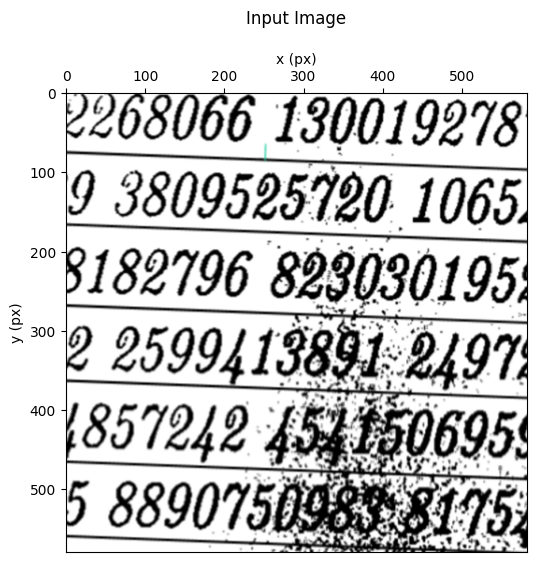

In [ ]:
img_path = "input.png"

try:
    origin_img = cv2.imread(img_path)
    if origin_img is None:
        print(f"Error: Can not read image with {img_path}")
except Exception as e:
    print(f"Load image fail due to: {e}")

show(
    size=(15, 15),
    imgs=[origin_img],
    titles=['Input Image\n'],
    grid=False
)

temp_img = origin_img.copy()

### **3. Preprocessing**

#### 3.1. Convert to gray-scale image

In [ ]:
gray = cv2.cvtColor(
    src=temp_img,
    code=cv2.COLOR_BGR2GRAY
)

#### 3.2. Image segmentation
* To facilitate localized processing, the input image was segmented into `12` individual cells. 
* The precise coordinates for each cell were identified through an experimental process of analyzing the image layout.

In [ ]:
def split_img(
    img: np.ndarray = None,
    box: tuple = None
) -> np.ndarray:

    y_start = box['y']
    y_end = box['y'] + box['h']
    x_start = box['x']
    x_end = box['x'] + box['w']
    splitted_img = img[y_start:y_end, x_start:x_end]

    return splitted_img

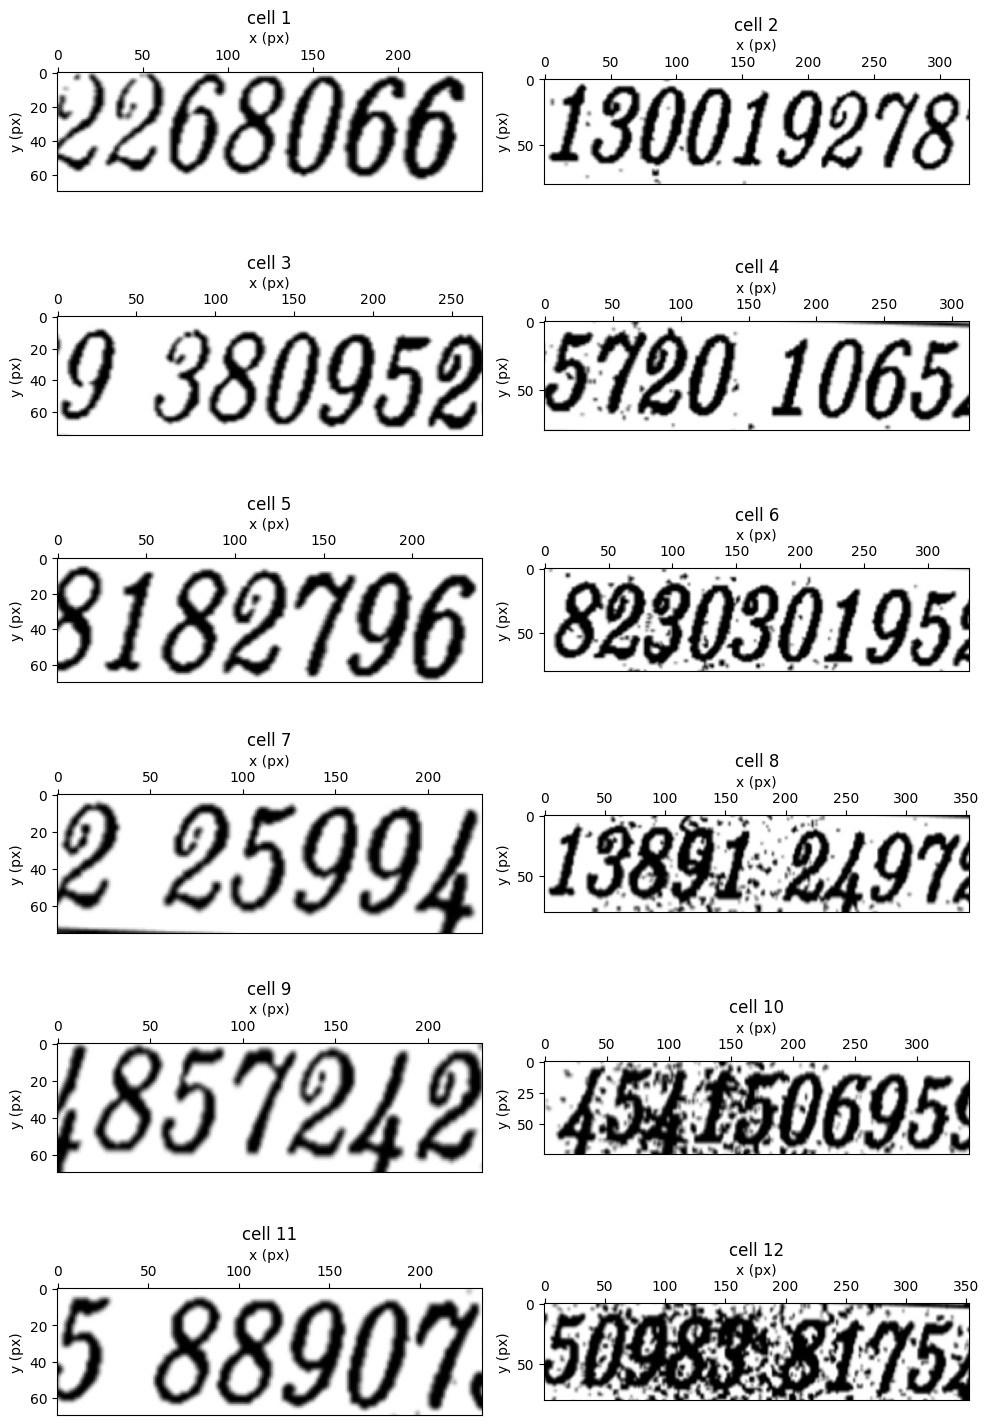

In [ ]:
coordinates_sys = [
    {"x": 0, "y": 0, "w": 250, "h": 70},        # CELL 1: Adjust h from 90 to 70
    {"x": 260, "y": 0, "w": 600, "h": 80},      # CELL 2: Adjust h from 90 to 70

    {"x": 0, "y": 90, "w": 270, "h": 75},       # CELL 3: Adjust h from 90 to 75
    {"x": 270, "y": 95, "w": 600, "h": 80},     # CELL 4: Adjust w from 280 to 270, h from 90 to 80

    {"x": 0, "y": 190, "w": 240, "h": 70},      # CELL 5: Adjust h from 90 to 70
    {"x": 250, "y": 190, "w": 600, "h": 80},    # CELL 6: Adjust h from 90 to 80

    {"x": 0, "y": 290, "w": 230, "h": 75},      # CELL 7: Adjust h from 90 to 70, to avoid the contact between number 4 and the hr line below
    {"x": 230, "y": 290, "w": 600, "h": 80},    # CELL 8

    {"x": 0, "y": 390, "w": 230, "h": 70},      # CELL 9
    {"x": 240, "y": 390, "w": 600, "h": 75},    # CELL 10

    {"x": 0, "y": 485, "w": 235, "h": 70},      # CELL 11
    {"x": 230, "y": 485, "w": 600, "h": 80},    # CELL 12
]

splitted_imgs = []
for row in coordinates_sys:
    splitted_imgs.append(
        split_img(
            img=temp_img,
            box=row
        )
    )

show(
    size=(10, 2.5),
    imgs=splitted_imgs,
    max_cols=2,
    # titles=[f"cell {i}.{j}" for i in range (1, 7, 1) for j in range (1, 3, 1)],
    titles=[f"cell {i}" for i in range (1, 13, 1)],
    axis=True,
    grid=False
)

### **4. Digit detection**

In [ ]:
def preprocess_cell(img, noise_type="low"):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if noise_type == "high":
        denoise = cv2.fastNlMeansDenoising(gray, None, 30, 7, 21)
        blur = cv2.GaussianBlur(denoise, (3, 3), 0)
        _, thresh = cv2.threshold(
            src=blur,
            thresh=5,
            maxval=255,
            type=cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )
        kernel = np.ones((2, 2), np.uint8)
        morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel, iterations=1)
    else:
        blur = cv2.GaussianBlur(gray, (3, 3), 0)
        _, thresh = cv2.threshold(
            blur,
            0,
            255,
            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )
        kernel = np.ones((2, 2), np.uint8)
        morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

    return morph

#### 4.1. Cell classification
* The 12 segmented image cells were classified into two primary categories based on visual quality:
  * **Group 1 (High-Noise Images)**: Images containing significant salt-and-pepper noise artifacts.
  * **Group 2 (Low-Noise Images)**: Images with minimal or no discernible noise.

In [ ]:
high_noise_idx = [6, 8, 10, 12]
low_noise_idx = [1, 2, 3, 4, 5, 7, 9, 11]

#### 4.2. High noise processing

In [ ]:
processed_cells = []
for i, img in enumerate(splitted_imgs, start=1):
    noise_type = "high" if i in high_noise_idx else "low"
    bin_img = preprocess_cell(img, noise_type)
    processed_cells.append(bin_img)

#### 4.3. Low noise processing

#### 4.4. Contour detection

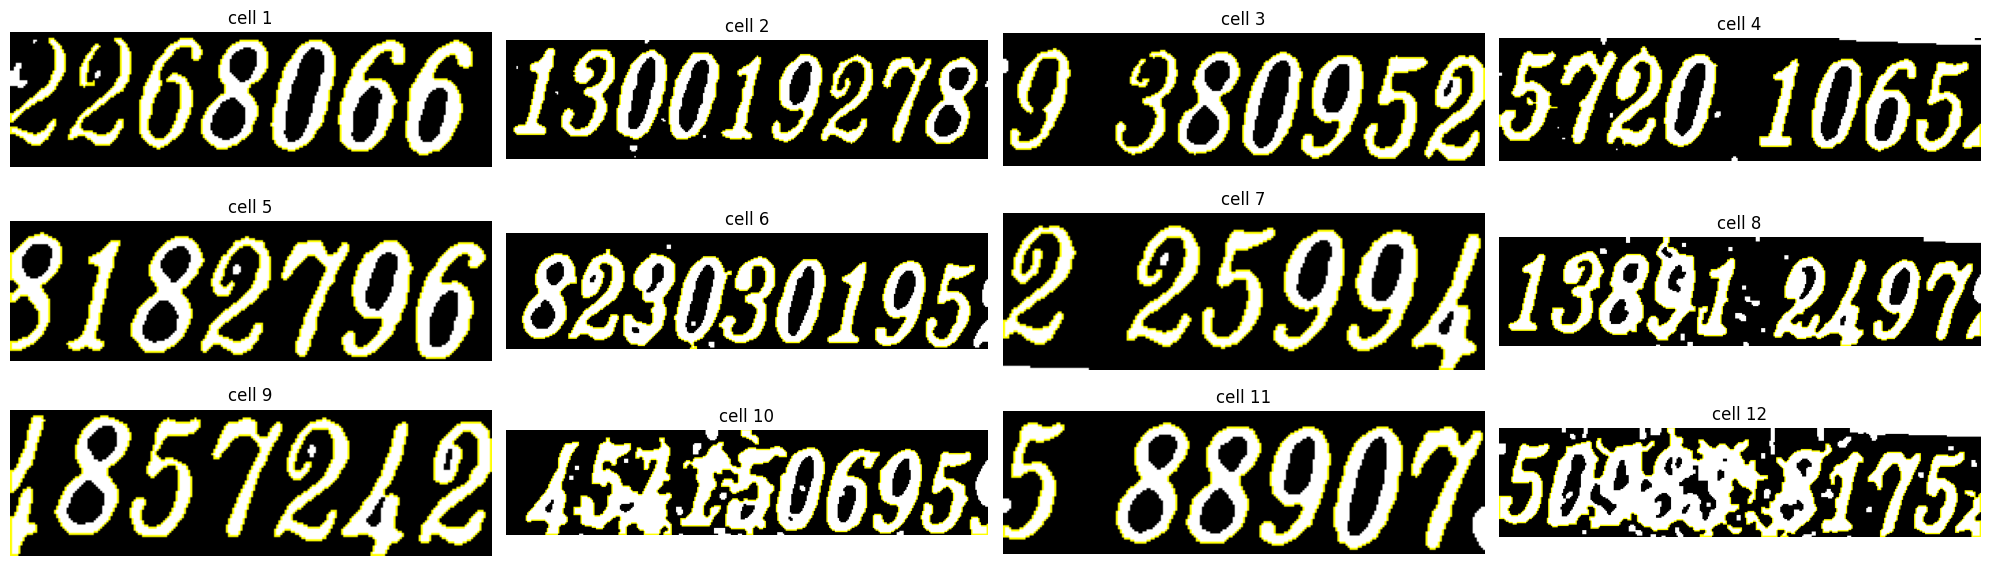

In [ ]:
digit_regions = []
visualized_contours = []

for i, cell in enumerate(processed_cells):
    vis = cv2.cvtColor(cell, cv2.COLOR_GRAY2BGR)
    contours, _ = cv2.findContours(cell, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cell_digits = []
    valid_contours = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        if MIN_HEIGHT < h < MAX_HEIGHT and MIN_WIDTH < w < MAX_WIDTH:
            digit = cell[y:y+h, x:x+w]
            cell_digits.append((x, digit))
            valid_contours.append(cnt)

    cell_digits.sort(key=lambda x: x[0])
    digit_regions.append([d[1] for d in cell_digits])

    cv2.drawContours(vis, valid_contours, -1, (0, 255, 255), 1)
    visualized_contours.append(vis)

show(
    imgs=visualized_contours,
    titles=[f"cell {i+1}" for i in range(len(visualized_contours))],
    max_cols=4,
    size=(20, 2),
    axis=False,
    grid=False
)


#### 4.5. Size standardization

In [ ]:
normalized_digits = []
for cell_digits in digit_regions:
    resized = [cv2.resize(d, (28, 28), interpolation=cv2.INTER_AREA) for d in cell_digits]
    normalized_digits.append(resized)

### **5. Results visualization**

cell 1: 7 digits
cell 2: 9 digits
cell 3: 7 digits
cell 4: 8 digits
cell 5: 7 digits
cell 6: 9 digits
cell 7: 6 digits
cell 8: 8 digits
cell 9: 7 digits
cell 10: 7 digits
cell 11: 6 digits
cell 12: 7 digits
Total digits detected: 88


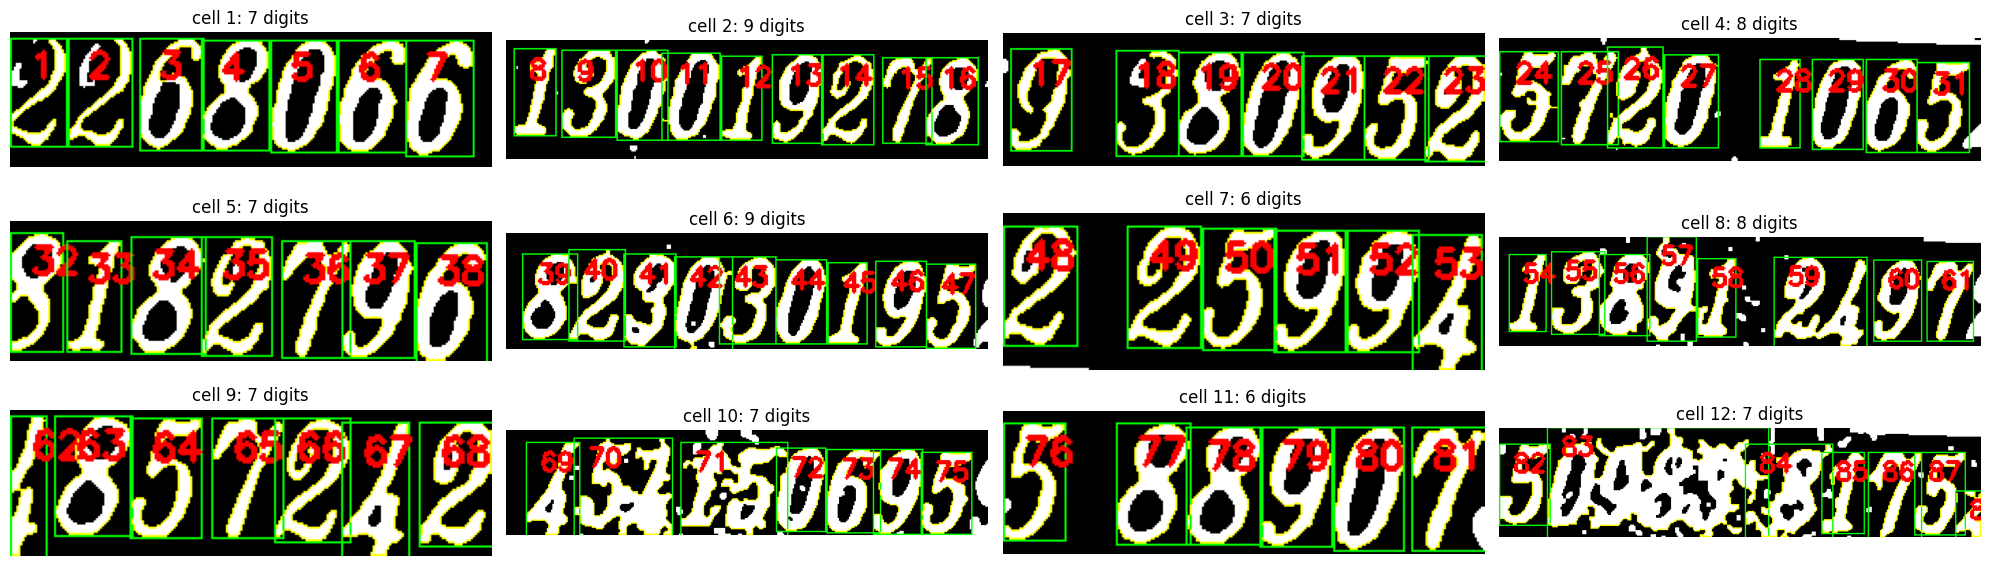

In [ ]:
digit_boxes = []
visualized_cells = []
titles = []
total = 0
digit_id = 1

kernel = np.ones((3, 3), np.uint8)

for i, cell in enumerate(processed_cells, start=1):
    if i in low_noise_idx:
        closed = cv2.morphologyEx(cell, cv2.MORPH_CLOSE, kernel)
    else:
        closed = cell

    vis = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)

    contours, _ = cv2.findContours(
        closed,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1] // 50, cv2.boundingRect(c)[0]))

    count = 0
    box = coordinates_sys[i - 1]
    offset_x, offset_y = box["x"], box["y"]

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if MIN_HEIGHT + 20 < h < MAX_HEIGHT and MIN_WIDTH < w < MAX_WIDTH:
            cv2.drawContours(vis, [cnt], -1, (0, 255, 255), 1)
            cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 1)
            cv2.putText(
                vis,
                str(digit_id),
                (x + 10, y + 20),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 0, 255),
                2
            )

            digit_boxes.append({
                "id": digit_id,
                "x": offset_x + x,
                "y": offset_y + y,
                "w": w,
                "h": h
            })

            digit_id += 1
            count += 1

    visualized_cells.append(vis)
    titles.append(f"cell {i}: {count} digits")
    total += count

for i, t in enumerate(titles, start=1):
    print(t)
print(f"Total digits detected: {total}")

show(
    imgs=visualized_cells,
    titles=titles,
    max_cols=4,
    size=(20, 2),
    axis=False,
    grid=False
)

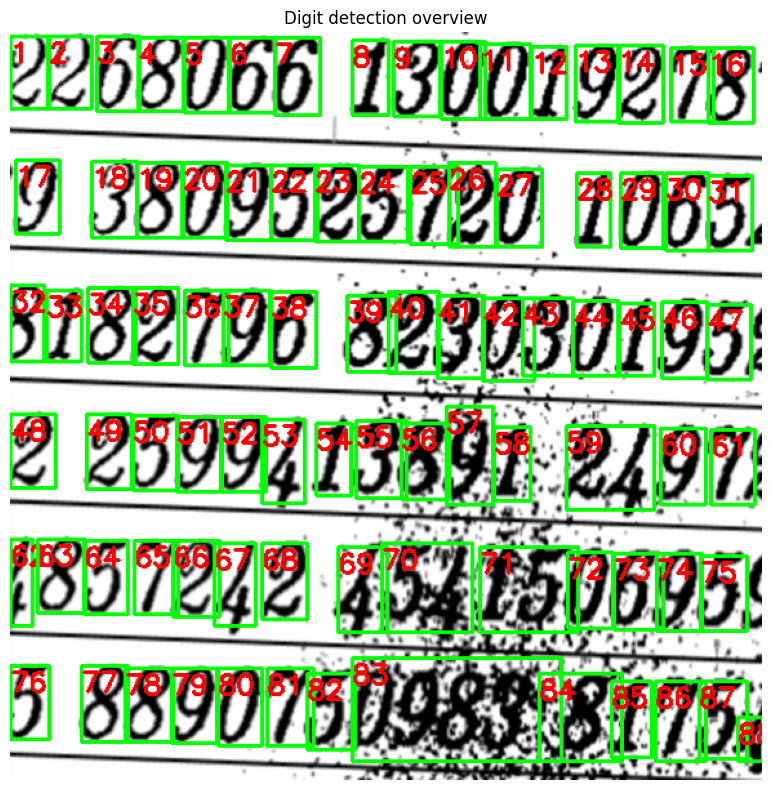

In [ ]:

vis_origin = cv2.cvtColor(origin_img, cv2.COLOR_BGR2GRAY)
vis_origin = cv2.cvtColor(vis_origin, cv2.COLOR_GRAY2BGR)

for d in digit_boxes:
    x, y, w, h = d["x"], d["y"], d["w"], d["h"]
    cv2.rectangle(vis_origin, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(
        vis_origin,
        str(d["id"]),
        (x, y + 20),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 0, 255),
        2
    )

show(
    imgs=[vis_origin],
    titles=["Digit detection overview"],
    max_cols=1,
    size=(8, 8),
    axis=False,
    grid=False
)


In [ ]:
cv2.imwrite("output_88_2.png", vis_origin)

In [ ]:
# TODO
"""
'24' cluster cell 8
'54', '15' cluster cell 10
'83' cluster cell 12
"""

### **6. Conclusion**